In [1]:
## Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Set path
import os
os.chdir('/content/drive/MyDrive/ADM_HW5')

In [3]:
## Import Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import pygraphviz
from tqdm import tqdm
from datetime import datetime, date, timedelta
from random import sample

# Import dependencies
import functionality_2 as f2

In [4]:
## Load Data
with open('sx-stackoverflow-a2q.txt') as f:
    a2q = f.readlines()
    f.close()

In [5]:
## Load Data
with open('sx-stackoverflow-c2q.txt') as f:
    c2q = f.readlines()
    f.close()

In [6]:
## Load Data
with open('sx-stackoverflow-c2a.txt') as f:
    c2a = f.readlines()
    f.close()

In [7]:
## Init Graph
G = nx.DiGraph()

In [8]:
## Merge Graph
t_start = datetime(2009, 10, 1)
t_end = datetime(2010, 10, 1)

for line in a2q:
    line = line.replace('\n', '')
    line = line.split(' ') 
    t = datetime.fromtimestamp(int(line[2]))
    t_truncated = date(t.year,t.month, t.day)
    if t_start <= t < t_end :
        if G.has_edge(line[0], line[1]) :
            G[line[0]][line[1]]['weight'] += 0.6
            G[line[0]][line[1]]['timestamp'].append(t_truncated)
        else :
            G.add_edge(line[0], line[1], weight=0.6)
            G[line[0]][line[1]]['timestamp']=[t_truncated]

for line in c2q:
    line = line.replace('\n', '')
    line = line.split(' ') 
    t = datetime.fromtimestamp(int(line[2]))
    t_truncated = date(t.year,t.month, t.day)
    if t_start <= t < t_end :
        if G.has_edge(line[0], line[1]) :
            G[line[0]][line[1]]['weight'] += 0.3
            G[line[0]][line[1]]['timestamp'].append(t_truncated)
        else :
            G.add_edge(line[0], line[1], weight=0.3)
            G[line[0]][line[1]]['timestamp']=[t_truncated]

for line in c2a:
    line = line.replace('\n', '')
    line = line.split(' ') 
    t = datetime.fromtimestamp(int(line[2]))
    t_truncated = date(t.year,t.month, t.day)
    if t_start <= t < t_end :
        if G.has_edge(line[0], line[1]) :
            G[line[0]][line[1]]['weight'] += 0.1
            G[line[0]][line[1]]['timestamp'].append(t_truncated)
        else :
            G.add_edge(line[0], line[1], weight=0.1)
            G[line[0]][line[1]]['timestamp']=[t_truncated]

### **Functionality 2 - Find the best users!**




In this functionality we create a subgraph of the original one, considering only the given interval of time. We have chosen to consider an interval of three days, in particular we take into account from `25/12/2009` to `27/12/2009`.

The user can choose between 4 metrics to analyze the feature of the selected user:
* **Beetweenness centrality**
* **PageRank score**
* **Closeness centrality**
* **Degree centrality**



#### **Beetweenness centrality**

The Beetweenness centrality of a given node $v$ is given by the ratio between the number of all-pairs shortest paths that pass through $v$ and the number of all possible shortest paths in the graph. Infact, we know that a node is important if it appears in many shortest paths.

$$
C_{B}(v) = \sum_{u,w \in V/\{v\}} \frac{g_{u,w}^{v}}{g_{u,w}} 
$$

Where $V$ are the nodes of the graph and $g_{u,w}^{v}$ are the shortest paths that pass through $v$ and $g_{u,w}$ are the all-pairs shortest paths in the graph.

In the implementation from scratch provided in this notebook we have managed an approximate solution. The algorithm will sample 100 nodes of the graph, (taking care that the chosen node is between them) and compute the beetweenness centrality of this subgraph. This is because our solution take a very long time to compute all the possible shorthest path of a ~4000 nodes graph.

This measure goes from $0$ to $1$ and it can tell us how much crucial our user was in the given interval of time. Higher the value is, higher is the probability to meet him through the path from an user to another.



#### **PageRank score**

PageRank computes a ranking of the nodes in the graph $G$ based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages. It measures the probability to arrive at the given node by randomly surfing around the nodes of the graph.

We can define the PageRank score of the i-th node as:

$$
\pi_{i} = \frac{\alpha}{n} + (1 - \alpha) \cdot \sum_{j:(j,i) \in E} \frac{\pi_{j}}{deg(j)}  
$$

Where $\alpha$ is the **damping parameter**, the probability of being teleportated from the node to another random node. At the end the formula consists in some fixed value plus the sum of the PageRank scores of the neigbhours weighted by the degree of the neighbours. 

We have implemented from scratch this function following the steps of the function implemented by [networkx](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html).

#### **Closeness centrality**

The Closeness centrality measure of a node $v$ is the reciprocal of the average shortest path distance beetween the node $v$ and all the other $n-1$ reachable nodes in the graph.

$$
C_{C}(v) = \frac{n-1}{\sum_{u \in V / \{v\}} d(v,u) }
$$

Where $d(v,u)$ are the distances of all the shortest paths.

It measures how much a node is close, in terms of distance, to all the other nodes in the graph. Obviously because it is an inverted average, more this value is small, more the measure is good.

#### **Degree centrality**

The Degree centrality for a node $v$ is the fraction of nodes it is connected to.

$$
C_{D}(v) = \frac{deg(v)}{n - 1}
$$

Where $deg(v)$ is the degree of the given node and $n-1$ is the maximum number of degree a node can have (when it has an edge with all the other nodes in the graph).

In [9]:
def funct_2(G, node, time_start, time_end, metric):
    '''
    Input:
        node <- a user/node
        time_start <- start of the interval of time
        time_end <- end of the interval of time
        metric <- one of the following metrics:
                    1. Betweenness
                    2. PageRank
                    3. Closeness Centrality
                    4. Degree Centrality
    Output:
        - The value of the given metric applied over the graph on the given 
          interval of time.
    '''
    subG = f2.my_subgraph(G, time_start, time_end)

    if metric == 1: # Betweenness centrality
        bt = f2.Beetweenness(subG, node)
        print(f'\nBetweenness centrality of {node}', bt) 
    
    elif metric == 2: # PageRank
        pr = f2.PageRank(subG, 0.25, node)
        print(f'PageRank score of {node}:', pr)

    elif metric == 3: # Closeness centrality
        cc = f2.Closeness(subG, node)
        print(f'\nCloseneess centrality of {node}', cc) 

    elif metric == 4: # Degree centrality
        degree_centrality = f2.Degree(subG, node)
        print(f'Degree centrality of {node}:', degree_centrality)
    
    else:
        print('Insert a valid metric!')

For this functionality we have chosen to focus on the user (node) $187606$, that seems to have been quite active during the chosen interval of time.

Compute the Beetweenness centrality of the user $187606$.

In [55]:
funct_2(G, '187606', date(2009, 12, 25), date(2009, 12, 27), 1)

100%|██████████| 100/100 [2:04:46<00:00, 74.87s/it]


Betweenness centrality of 187606 0.0295


The user $187606$ has a **Beetweenness centrality** of **0.0295**. It means that (for the 100-nodes sample) almost 3% of the shortest paths pass through that node.

### **Visualization 2**

This is the function for the second visualization. It will plot the node with all its neighbours, it means the user with all the other users with he has interacted in the given interval of time. 

The edges has a different color according to the different type of relationship between the users: it will be darker for an answer to a query and lighter for a comment to an answer.

In addition it will plot the chosen metric evolution into the individual days of the given interval of time.

In [10]:
def viz_2(G):
    '''
    Input:
        - node : the node we are interested in
        - time_start / time_end : the interval of time we are interested in
        - metric : one of the following metrics:
                    1. Betweenness
                    2. PageRank
                    3. Closeness Centrality
                    4. Degree Centrality
    '''
    print('Insert your node:')
    node = str(input())

    print('Insert the first day of the time interval desired: [yyyy/mm/dd]')
    t1 = datetime.strptime(input(), '%Y/%m/%d')
    time_start = date(t1.year, t1.month, t1.day)

    print('Insert the last day of the time interval desired: [yyyy/mm/dd]')
    t2 = datetime.strptime(input(), '%Y/%m/%d')
    time_end = date(t2.year, t2.month, t2.day)

    print('Select your metric!')
    print('Type 1 for Betweenness centrality')
    print('Type 2 for PageRank score')
    print('Type 3 for Closeness centrality')
    print('Type 4 for Degree centrality')
    metric = int(input())

    if metric == 1:
        print('You have chosen Betweenness centrality! Wait for your results...')

    elif metric == 2:
        print('You have chosen PageRank score! Wait for your results...')

    elif metric == 3:
        print('You have chosen Closeness centrality! Wait for your results...')

    elif metric == 4:
        print('You have chosen Degree centrality! Wait for your results...')

    subG = f2.my_subgraph(G, time_start, time_end)

    funct_2(subG, node, time_start, time_end, metric)
    
    f2.my_neighs(subG, node)

    f2.metric_evolution(subG, time_start, time_end, node, metric)

Let's do this for the PageRank metric!

Insert your node:
187606
Insert the first day of the time interval desired: [yyyy/mm/dd]
2009/12/25
Insert the last day of the time interval desired: [yyyy/mm/dd]
2009/12/27
Select your metric!
Type 1 for Betweenness centrality
Type 2 for PageRank score
Type 3 for Closeness centrality
Type 4 for Degree centrality
2
You have chosen PageRank score! Wait for your results...
PageRank score of 187606: 0.0007966033682331506


<Figure size 432x288 with 0 Axes>

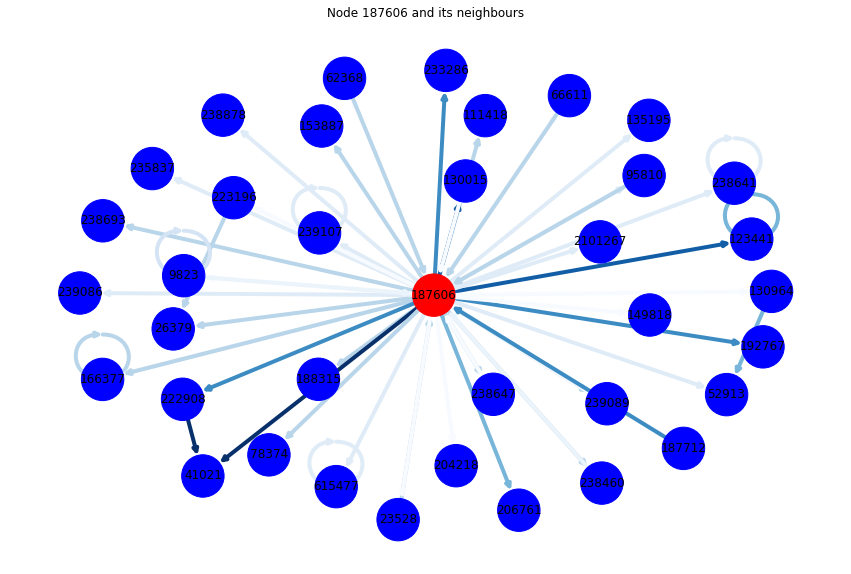

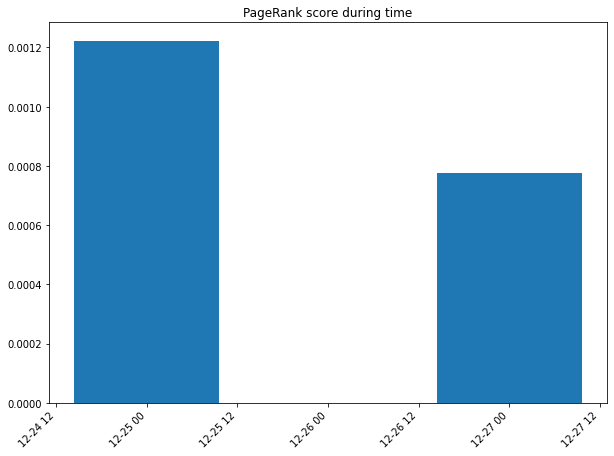

In [11]:
viz_2(G)

The user $187606$ has a **PageRank score** of **0.0008**. It means that the probability to reach him, starting from a random user, in that interval of time are quite low. But it's normal because we are considering a very huge graph.

We can see how he had a strong connection with the user $41021$ because the edge color is darker than the others.

Analyzing the score over the interval of three days we immediately notice that on December 26 the score is equal to 0. It means that reaching that user it's impossible, maybe because he didn't have interaction that day and so he disappeared from the subgraph or that the PageRank algorithm didn't converged. Moreover, on December 25 he had an high score (~0.0012) and a low one on December 27. We can say that this user had more interactions and he was more active on the Christmas day.

Now, let's try the Closeness centrality!

Insert your node:
187606
Insert the first day of the time interval desired: [yyyy/mm/dd]
2009/12/25
Insert the last day of the time interval desired: [yyyy/mm/dd]
2009/12/27
Select your metric!
Type 1 for Betweenness centrality
Type 2 for PageRank score
Type 3 for Closeness centrality
Type 4 for Degree centrality
3
You have chosen Closeness centrality! Wait for your results...


100%|██████████| 3995/3995 [39:17<00:00,  1.69it/s]



Closeneess centrality of 187606 0.6901689987279684


100%|██████████| 1772/1772 [03:33<00:00,  8.28it/s]


<Figure size 432x288 with 0 Axes>

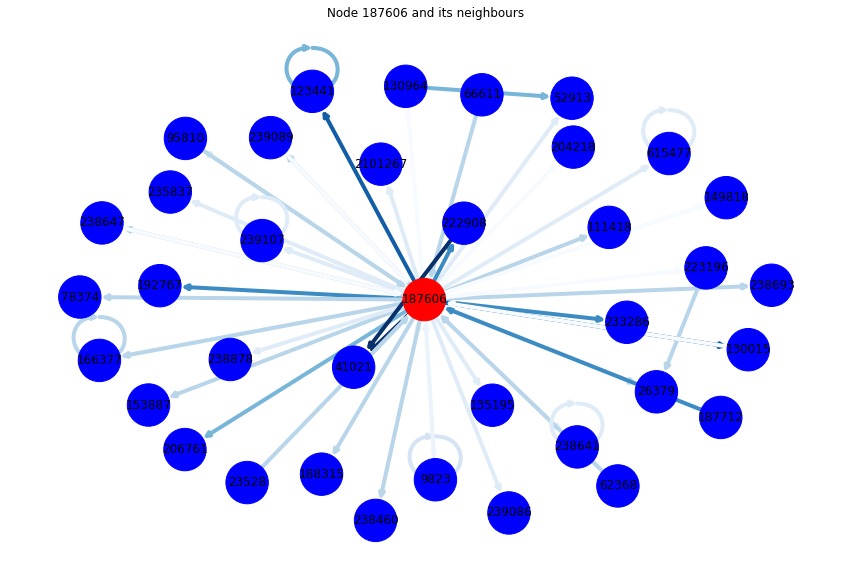

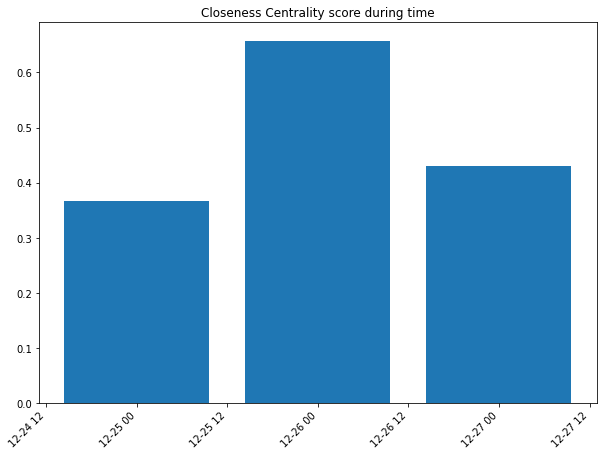

In [11]:
viz_2(G)

The user $187606$ has a **Closeness centrality** of **0.69**. It means that its average distance from all the other nodes he can reach is 1.45.

We can observe from the metric evolution that the day with the highest closeness centrality is December 26 and the day with the lowest one is December 25. It means that on December 26 the average shortest path distance between the user and all the others on StackOverflow was less than the other days.

Finally, try with Degree centrality!

Insert your node:
187606
Insert the first day of the time interval desired: [yyyy/mm/dd]
2009/12/25
Insert the last day of the time interval desired: [yyyy/mm/dd]
2009/12/27
Select your metric!
Type 1 for Betweenness centrality
Type 2 for PageRank score
Type 3 for Closeness centrality
Type 4 for Degree centrality
4
You have chosen Degree centrality! Wait for your results...
Degree centrality of 187606: 0.015523284927391086


<Figure size 432x288 with 0 Axes>

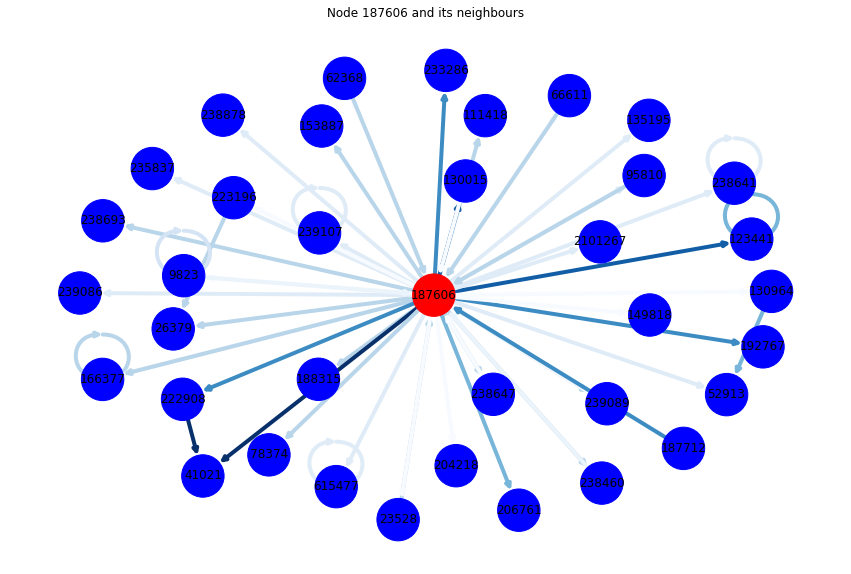

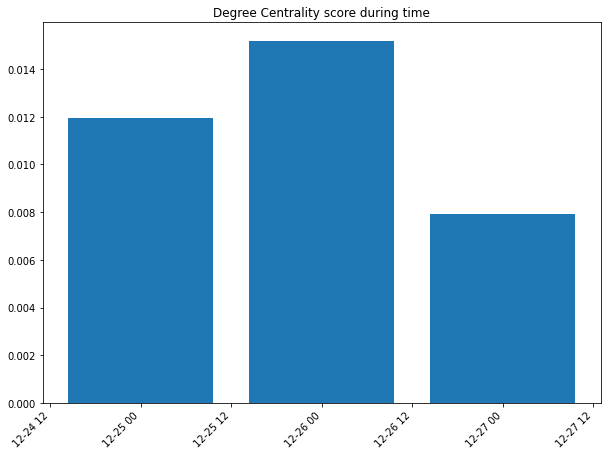

In [12]:
viz_2(G)

The user $187606$ has a **Degree centrality** score of **0.015**, it means that in the given interval of time he had interacted with the 1.5% of the reachable nodes. If we consider that there are 3995 nodes, it means that in three days he interacted with almost 60 different users, quite a lot!

From the metric evolution we can see that he has the best result on December 26 and the lowest one on December 27.